In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
#print(df.describe())
df = pd.read_csv('02-21-2018.csv')
feature_names = df.columns
feature_list = list(feature_names)
print(feature_list)

['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd By

Method 1: 基础算法，人工筛选一些features，算阈值，进行检测判断

In [3]:
%%time
df = pd.read_csv('02-21-2018.csv')
df_ddos_true = df[df['Label'].str.contains("DDOS", case=False)]

# 指定的特征
features = ['Flow Pkts/s', 'Flow Byts/s', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 'Tot Fwd Pkts', 'Init Fwd Win Byts', 'Fwd IAT Tot', 'Pkt Size Avg', 'Flow Duration', 'Fwd Pkts/s', 'PSH Flag Cnt', 'Fwd PSH Flags', 'Fwd Pkt Len Max']

# 动态计算阈值并保存到字典中
thresholds = {feature: df[feature].quantile(0.7) for feature in features}

# 打印计算出的分位数阈值，确保正确无误
# for feature, threshold in thresholds.items():
#     print(f"{feature}‘s the 80th-percentile: {threshold}")

# 标记可能的DDoS攻击
df['is_ddos_pred'] = df.apply(lambda row: sum(row[feature] > thresholds[feature] for feature in thresholds) >= 1, axis=1)

CPU times: user 1min 1s, sys: 2.3 s, total: 1min 3s
Wall time: 1min 3s


In [4]:
# 提取索引集合
true_ddos_indices = set(df_ddos_true.index)
predicted_ddos_indices = set(df[df['is_ddos_pred'] == True].index)
all_indices = set(df.index)

# 计算指标
true_positives = len(true_ddos_indices & predicted_ddos_indices)
false_positives = len(predicted_ddos_indices - true_ddos_indices)
false_negatives = len(true_ddos_indices - predicted_ddos_indices)
true_negatives = len(all_indices - true_ddos_indices - predicted_ddos_indices)

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
accuracy = (true_positives + true_negatives) / len(all_indices) if len(all_indices) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 真正例占被标记为DDoS流量的百分比（即召回率）
recall_percentage = recall * 100
# 打印结果
print(f"真正例 (正确识别的DDoS): {true_positives}")
print(f"假正例 (错误标记为DDoS): {false_positives}")
print(f"假负例 (未识别的DDoS): {false_negatives}")
# 打印统计学指标
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f} ({recall_percentage:.2f}%)")
print(f"F1分数 (F1 Score): {f1_score:.4f}")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"特异性 (Specificity): {specificity:.4f}")

# 总结
print(f"\n总结：我们的算法在原始数据集中找到了被标记为DDoS的流量的 {recall_percentage:.2f}%。")

真正例 (正确识别的DDoS): 372039
假正例 (错误标记为DDoS): 353705
假负例 (未识别的DDoS): 315703
精确率 (Precision): 0.5126
召回率 (Recall): 0.5410 (54.10%)
F1分数 (F1 Score): 0.5264
准确率 (Accuracy): 0.3616
特异性 (Specificity): 0.0198

总结：我们的算法在原始数据集中找到了被标记为DDoS的流量的 54.10%。


Method 2: 根据不同DDOS攻击类型的特性，分别设置识别条件

In [5]:
%%time
df = pd.read_csv('02-21-2018.csv')

# 假设已经有了筛选出真实DDoS标签的数据
df_ddos_true = df[df['Label'].str.contains("DDOS", case=False)]

# 指定的特征和基于攻击类型的动态阈值设置
features = ['Flow Pkts/s', 'Flow Byts/s', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 
            'Tot Fwd Pkts', 'Init Fwd Win Byts', 'Fwd IAT Tot', 'Pkt Size Avg', 
            'Flow Duration', 'Fwd Pkts/s', 'PSH Flag Cnt', 'Fwd PSH Flags', 
            'Fwd Pkt Len Max']

# 动态计算95%分位数作为阈值
thresholds = {feature: df[feature].quantile(0.7) for feature in features}

# 根据不同的攻击特点调整阈值
# 注意：这里的阈值需要根据具体数据和攻击行为进行调整
# 例如，LOIC-UDP可能导致特别高的Flow Pkts/s，而HOIC可能导致高SYN Flag Cnt
# 这里仅提供一种基于现有特征调整阈值的示例方法
attack_type_adjustments = {
    'Flow Pkts/s': 1.2,  # 假设LOIC-UDP会导致更高的包速率
    'SYN Flag Cnt': 1.5,  # 假设HOIC攻击会有更多的SYN标志
}

# 应用调整
for feature, adjustment in attack_type_adjustments.items():
    if feature in thresholds:
        thresholds[feature] *= adjustment

# 标记可能的DDoS攻击
df['is_ddos_pred'] = df.apply(lambda row: sum(row[feature] > thresholds[feature] for feature in features) >= 2, axis=1)

CPU times: user 1min 5s, sys: 2.15 s, total: 1min 7s
Wall time: 1min 7s


In [6]:
# 提取索引集合
true_ddos_indices = set(df_ddos_true.index)
predicted_ddos_indices = set(df[df['is_ddos_pred'] == True].index)
all_indices = set(df.index)

# 计算指标
true_positives = len(true_ddos_indices & predicted_ddos_indices)
false_positives = len(predicted_ddos_indices - true_ddos_indices)
false_negatives = len(true_ddos_indices - predicted_ddos_indices)
true_negatives = len(all_indices - true_ddos_indices - predicted_ddos_indices)

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
accuracy = (true_positives + true_negatives) / len(all_indices) if len(all_indices) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 真正例占被标记为DDoS流量的百分比（即召回率）
recall_percentage = recall * 100
# 打印结果
print(f"真正例 (正确识别的DDoS): {true_positives}")
print(f"假正例 (错误标记为DDoS): {false_positives}")
print(f"假负例 (未识别的DDoS): {false_negatives}")
# 打印统计学指标
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f} ({recall_percentage:.2f}%)")
print(f"F1分数 (F1 Score): {f1_score:.4f}")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"特异性 (Specificity): {specificity:.4f}")

# 总结
print(f"\n总结：我们的算法在原始数据集中找到了被标记为DDoS的流量的 {recall_percentage:.2f}%。")

真正例 (正确识别的DDoS): 302071
假正例 (错误标记为DDoS): 336127
假负例 (未识别的DDoS): 385671
精确率 (Precision): 0.4733
召回率 (Recall): 0.4392 (43.92%)
F1分数 (F1 Score): 0.4556
准确率 (Accuracy): 0.3116
特异性 (Specificity): 0.0685

总结：我们的算法在原始数据集中找到了被标记为DDoS的流量的 43.92%。


In [7]:
# 获取'Label'列的所有唯一值
unique_labels = df['Label'].unique()

# 计算唯一值的数量
number_of_unique_labels = len(unique_labels)

# 打印结果
print(f"'Label'列一共有 {number_of_unique_labels} 种不同的值。")

# 如果你也想看看这些具体的值是什么
print("这些值包括：", unique_labels)

'Label'列一共有 3 种不同的值。
这些值包括： ['Benign' 'DDOS attack-LOIC-UDP' 'DDOS attack-HOIC']


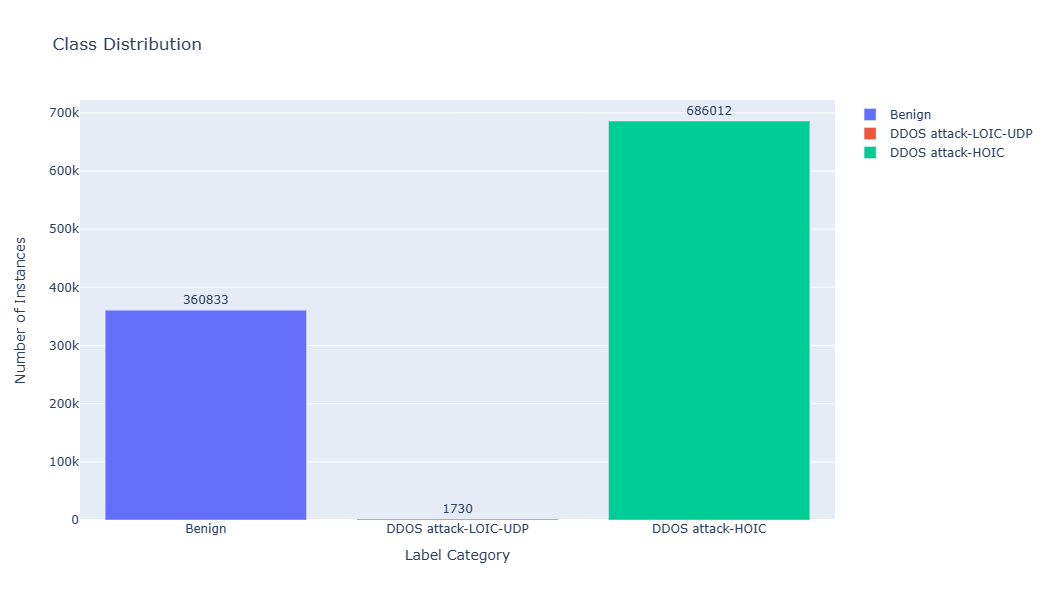

In [8]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
import plotly.graph_objs as go

init_notebook_mode(connected=True)

# 使用df["Label"].value_counts()获取标签分布
df = pd.read_csv('02-21-2018.csv')
label_counts = df["Label"].value_counts()

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=[label_counts['Benign']],
           x=['Benign'],
           text=[label_counts['Benign']],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDOS attack-LOIC-UDP', 
           y=[label_counts['DDOS attack-LOIC-UDP']],
           x=['DDOS attack-LOIC-UDP'],
           text=[label_counts['DDOS attack-LOIC-UDP']],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDOS attack-HOIC', 
           y=[label_counts['DDOS attack-HOIC']],
           x=['DDOS attack-HOIC'],
           text=[label_counts['DDOS attack-HOIC']],
           orientation='v',
           textposition='outside',)
])

# 修改布局设置
fig.update_layout(
    width=800,
    height=600,
    title='Class Distribution',
    yaxis_title='Number of Instances',
    xaxis_title='Label Category',
)

iplot(fig)